In [68]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv("/content/market_comments.csv")
df.head()

,item_category,item_id,brand,user_id,date,comment,rating,tonality
0,401,4010201,826,2217,2013-06-28,"2,5 года работала и все...устала! Лампочка гор...",2.0,negative
1,403,4030101,1425,1026,2010-07-04,Через 2 месяца после истечении гарантийного ср...,2.0,negative
2,401,4010401,124,2769,2010-05-27,пользуюсь уже три недели. нареканий ни каких н...,4.0,positive
3,203,2030301,93,508,2016-10-11,Ребят этот системный блок подойдёт для игры кс...,5.0,positive
4,205,2050201,656,1049,2010-02-26,"я считаю, что яри замечательный телефон! Прият...",5.0,positive


In [3]:
#Check for Missing values :
df.isnull().sum()

,0
item_category,0
item_id,0
brand,0
user_id,0
date,0
comment,0
rating,0
tonality,0


In [4]:
df.duplicated().sum()

np.int64(0)

In [5]:
# Text Normalization
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('russian'))  # Use 'english' if your data is in English
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub('[^а-яА-Яa-zA-Z]', ' ', text)  # Keep letters only
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return ' '.join(text)

df['clean_comment'] = df['comment'].apply(clean_text)

# Step 3: Label Encoding
label_encoder = LabelEncoder()
df['tonality_encoded'] = label_encoder.fit_transform(df['tonality'])  # positive → 1, negative → 0

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
# Encoding other categorical features
df['brand'] = LabelEncoder().fit_transform(df['brand'])
df['item_category'] = LabelEncoder().fit_transform(df['item_category'])

In [7]:
# Now ready for vectorization/tokenization for DL models
df[['comment', 'clean_comment', 'tonality', 'tonality_encoded']].head()

,comment,clean_comment,tonality,tonality_encoded
0,"2,5 года работала и все...устала! Лампочка гор...",года работала устала лампочка горит,negative,0
1,Через 2 месяца после истечении гарантийного ср...,месяца истечении гарантийного срока машинка на...,negative,0
2,пользуюсь уже три недели. нареканий ни каких н...,пользуюсь недели нареканий каких положительные...,positive,1
3,Ребят этот системный блок подойдёт для игры кс...,ребят системный блок подойд т игры кс го средн...,positive,1
4,"я считаю, что яри замечательный телефон! Прият...",считаю яри замечательный телефон приятно держа...,positive,1


**TRAIN-TEST SPLIT**

In [8]:
# Train-Test Split
X = df['clean_comment']
y = df['tonality_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

**BAG OF WORDS**

In [10]:
# Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [11]:
smote = SMOTE(random_state=42)
X_train_bow, y_train_resampled = smote.fit_resample(X_train_bow, y_train)

In [12]:
# Random Forest
rf = RandomForestClassifier(n_estimators=400)
rf.fit(X_train_bow, y_train_resampled)
pred_rf = rf.predict(X_test_bow)
print("Random Forest (BoW):\n", classification_report(y_test, pred_rf))

Random Forest (BoW):
               precision    recall  f1-score   support

           0       0.51      0.41      0.46       478
           1       0.89      0.92      0.90      2379

    accuracy                           0.84      2857
   macro avg       0.70      0.67      0.68      2857
weighted avg       0.82      0.84      0.83      2857



In [13]:
# XGBoost
xgb = XGBClassifier(n_estimators = 400, eval_metric='logloss')
xgb.fit(X_train_bow, y_train_resampled)
pred_xgb = xgb.predict(X_test_bow)
print("XGBoost (BoW):\n", classification_report(y_test, pred_xgb))

XGBoost (BoW):
               precision    recall  f1-score   support

           0       0.69      0.64      0.67       478
           1       0.93      0.94      0.94      2379

    accuracy                           0.89      2857
   macro avg       0.81      0.79      0.80      2857
weighted avg       0.89      0.89      0.89      2857



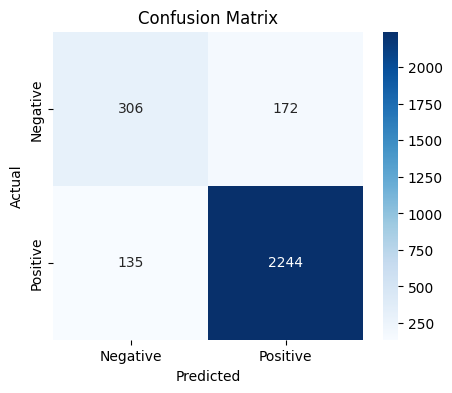

In [67]:
cm = confusion_matrix(y_test, pred_xgb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
# AdaBoost
ada = AdaBoostClassifier(n_estimators= 400)
ada.fit(X_train_bow, y_train_resampled)
pred_ada = ada.predict(X_test_bow)
print("AdaBoost (BoW):\n", classification_report(y_test, pred_ada))

AdaBoost (BoW):
               precision    recall  f1-score   support

           0       0.33      0.70      0.45       478
           1       0.92      0.72      0.81      2379

    accuracy                           0.71      2857
   macro avg       0.63      0.71      0.63      2857
weighted avg       0.82      0.71      0.75      2857



**TF-IDF**

In [15]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [16]:
smote = SMOTE(random_state=42)
X_train_tfidf, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [17]:
# Random Forest
rf = RandomForestClassifier(n_estimators=400)
rf.fit(X_train_tfidf, y_train_resampled)
pred_rf_tfidf = rf.predict(X_test_tfidf)
print("Random Forest (TF-IDF):\n", classification_report(y_test, pred_rf_tfidf))

Random Forest (TF-IDF):
               precision    recall  f1-score   support

           0       0.65      0.51      0.57       478
           1       0.91      0.94      0.92      2379

    accuracy                           0.87      2857
   macro avg       0.78      0.73      0.75      2857
weighted avg       0.86      0.87      0.87      2857



In [18]:
# XGBoost
xgb = XGBClassifier(n_estimators = 400, eval_metric='logloss')
xgb.fit(X_train_tfidf, y_train_resampled)
pred_xg_tfidf = rf.predict(X_test_tfidf)
print("XGBoost (TF-IDF):\n", classification_report(y_test, pred_xg_tfidf))

XGBoost (TF-IDF):
               precision    recall  f1-score   support

           0       0.65      0.51      0.57       478
           1       0.91      0.94      0.92      2379

    accuracy                           0.87      2857
   macro avg       0.78      0.73      0.75      2857
weighted avg       0.86      0.87      0.87      2857



In [19]:
# AdaBoost
ada = AdaBoostClassifier(n_estimators= 400)
ada.fit(X_train_tfidf, y_train_resampled)
pred_ada_tfidf = rf.predict(X_test_tfidf)
print("AdaBoost (TF-IDF):\n", classification_report(y_test, pred_ada_tfidf))

AdaBoost (TF-IDF):
               precision    recall  f1-score   support

           0       0.65      0.51      0.57       478
           1       0.91      0.94      0.92      2379

    accuracy                           0.87      2857
   macro avg       0.78      0.73      0.75      2857
weighted avg       0.86      0.87      0.87      2857



**USING EMBEDDING**

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU

In [21]:
# Tokenization
max_words = 5000  # Vocabulary size
max_len = 100     # Max length of a comment

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_comment'])
sequences = tokenizer.texts_to_sequences(df['clean_comment'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['tonality_encoded'], test_size=0.2, random_state=42)


In [36]:
# Build LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification (positive/negative)
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 100, 64)             │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 555,201 (2.12 MB)

 Trainable params: 555,201 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8326 - loss: 0.4754 - val_accuracy: 0.8327 - val_loss: 0.4517
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8394 - loss: 0.4421 - val_accuracy: 0.8327 - val_loss: 0.4516
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8424 - loss: 0.4371 - val_accuracy: 0.8327 - val_loss: 0.4526
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8333 - loss: 0.4524 - val_accuracy: 0.8327 - val_loss: 0.4518
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8306 - loss: 0.4554 - val_accuracy: 0.8327 - val_loss: 0.4515
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8389 - loss: 0.4416 - val_accuracy: 0.8327 - val_loss: 0.4517
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8410 - loss: 0.4367 - val_accuracy: 0.8327 - val_loss: 0.4514
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8318 - loss: 0.4505 - val_accu

In [38]:
import matplotlib.pyplot as plt

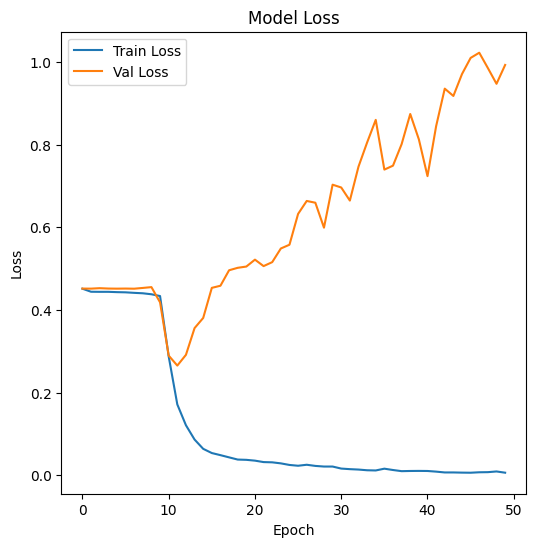

In [39]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [40]:
y_pred_ann = model.predict(X_test)
y_pred_ann = np.where(y_pred_ann > 0.5, 1, 0)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [41]:
print(classification_report(y_test, y_pred_ann))

              precision    recall  f1-score   support

           0       0.67      0.62      0.64       478
           1       0.92      0.94      0.93      2379

    accuracy                           0.88      2857
   macro avg       0.79      0.78      0.79      2857
weighted avg       0.88      0.88      0.88      2857



**Bi-directional LSTM**

In [59]:
model = Sequential([Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
                    Bidirectional(LSTM(units=128, return_sequences=False)),
                    Dense(1, activation='sigmoid')])
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, max_len))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 100, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 734,753 (2.80 MB)

 Trainable params: 734,753 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8442 - loss: 0.4303 - val_accuracy: 0.8855 - val_loss: 0.2978
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9181 - loss: 0.2076 - val_accuracy: 0.9020 - val_loss: 0.2469
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9536 - loss: 0.1244 - val_accuracy: 0.8992 - val_loss: 0.2665
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9684 - loss: 0.0856 - val_accuracy: 0.8939 - val_loss: 0.3066
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9745 - loss: 0.0744 - val_accuracy: 0.8939 - val_loss: 0.4268
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9827 - loss: 0.0491 - val_accuracy: 0.8880 - val_loss: 0.4316
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9858 - loss: 0.0402 - val_accuracy: 0.8866 - val_loss: 0.4868
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9894 - loss: 0.0312 - val_accu

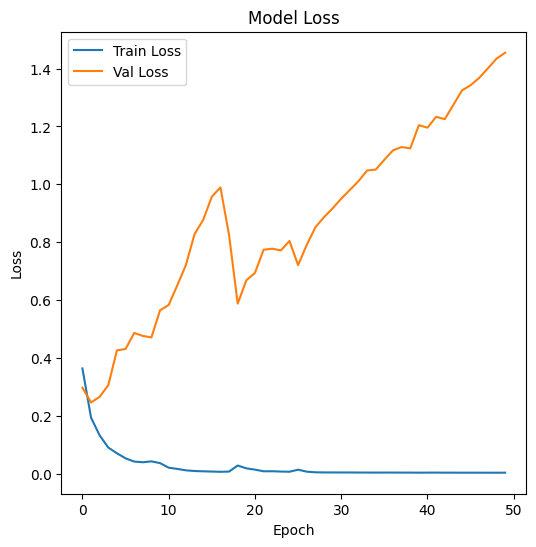

In [61]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [62]:
y_pred_bi = model.predict(X_test)
y_pred_bi = np.where(y_pred_bi > 0.5, 1, 0)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [63]:
print(classification_report(y_test, y_pred_bi))

              precision    recall  f1-score   support

           0       0.64      0.60      0.62       478
           1       0.92      0.93      0.93      2379

    accuracy                           0.88      2857
   macro avg       0.78      0.77      0.77      2857
weighted avg       0.87      0.88      0.88      2857



In [64]:
import seaborn as sns

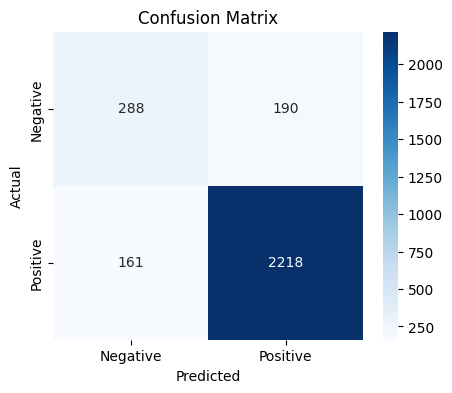

In [66]:
cm = confusion_matrix(y_test, y_pred_bi)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [52]:
#GRU-LSTM
model = Sequential([Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
                    GRU(units=128, return_sequences=True),
                    LSTM(units=64, return_sequences=False),
                    Dropout(0.5),
                    Dense(1, activation='sigmoid')
])
# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and summary
model.build((None, max_len))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 100, 128)            │          88,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 637,793 (2.43 MB)

 Trainable params: 637,793 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8197 - loss: 0.4811 - val_accuracy: 0.8327 - val_loss: 0.4543
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8333 - loss: 0.4566 - val_accuracy: 0.8327 - val_loss: 0.4526
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8391 - loss: 0.4469 - val_accuracy: 0.8327 - val_loss: 0.4515
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8395 - loss: 0.4453 - val_accuracy: 0.8327 - val_loss: 0.4520
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8359 - loss: 0.4508 - val_accuracy: 0.8309 - val_loss: 0.4548
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8384 - loss: 0.4480 - val_accuracy: 0.8320 - val_loss: 0.3404
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8822 - loss: 0.2827 - val_accuracy: 0.9016 - val_loss: 0.2559
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9485 - loss: 0.1436 - val_accu

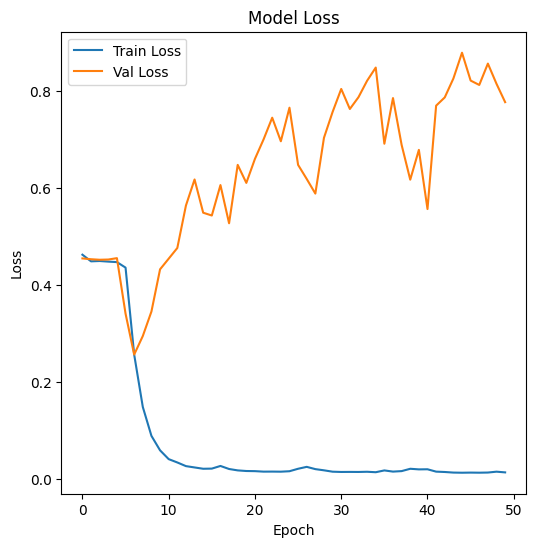

In [54]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [57]:
y_pred_gru = model.predict(X_test)
y_pred_gru = np.where(y_pred_gru > 0.5, 1, 0)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [58]:
print(classification_report(y_test, y_pred_gru))

              precision    recall  f1-score   support

           0       0.61      0.63      0.62       478
           1       0.93      0.92      0.92      2379

    accuracy                           0.87      2857
   macro avg       0.77      0.77      0.77      2857
weighted avg       0.87      0.87      0.87      2857

